# EDA with ERiC

## Implementation

The correlation clustering algorithm ERiC is implemented in the *lib.py* file, which contains several key methods:


* *make_partitions(D, k, α)*   
This method takes the full data set D and the hyperparameter k and α and assigns a dimensionality $\lambda$ to every point, which represents the partition in which it is in. The parameter k determines the size of the nearest neighbourhood of point p, which is used for computing the eigenvalue decomposition. The parameter α determines the portion of explained variance, and it is usually between 0.8 and 0.9, in our case it is 0.85 by default.Some partitions might remain empty. Partition $P_d$ contains noise, since there is no linear dependency of features within the neighborhood of point p.



* *cluster_partitions(D, partitions, $\Delta$, δ, min_samples)*  
Performs DBSCAN to compute clusters within each partition, using a custom function for calculating the distances between the points - the correlation function. The hyperparameters used are $\Delta$, used for determining the approximate linear dependency, while parameter δ for the affine distance. The input parameter ε determining the range of neighborhood is set to a value very close to 0 since the output of the correlation distance function is either 0 or 1. The parameter min_samples determines the minimum size of a cluster. 


* *build_hierarchy(cluster_list, $\Delta$, δ)*  
As input contains a list of clusters, sorted by its $\lambda$ value. The method assignes the parents for each cluster. If the correlation distance between two clusters is 0, then cluster $C_n$ is treated as parent of cluster $C_m$, unless $C_n$ is a parent of any cluster $C_o$ that in turn is already a parent of $C_m$, because in that case the relationship between $C_n$ and $C_m$ is that of a grandparent.


The validation of the implementation of the algorithm is carried out in the notebook [ERiC_Validation.ipynb](http://localhost:8888/notebooks/ERiC_Validation.ipynb) Here, one can also see an example how to run ERiC and ELKI ERiC and look at the results.

## Hyperparameters

The hyperparameter tunning is carried out in the file: *hyperparameter_tuning.py* which helped us pick the hyperparameters to run the different kernels with.

We have tried several combinations of the following hyperparameters: k, Δ and δ. For analyzing the results, since it is not straight forward to compute the NMI since we have groups of cluster for every dimensions, which are connected between dimensions, we plotted them by ordering them in the same horizontal line - correspoding to the descending 𝜆 value, and coloring the nodes by with a color between blue and red, indicating the amount of presence of the two labels (purple color means there are somewhat equal amounts of both values present in the cluster). This is produced by the function *draw_graph* in the *elki_parser.py* file.

The minPts parameter for DBSCAN is set to 2 by default, since there are already a lot of points showing up in the noise cluster, and in the EDA.ipynb notebook it has been shown that a greater value of this parameters accumulates more noisy points.


The plots from the hyperparameter tuning can be found in *plot_trees.ipynb*.

##### Note:  Limitations

* Parameter k  
The paper of the algorithm states that k needs to be much larger then the dimensionality of the data. However, our dataset has the same number of samples as features (both being 1000). Due to this reason we had to chose k either equal to d (which will not produce meaningful results) or smaller. We chose several values of k (100, 250 and 500). In any case, the results did not seem meaningful as the hierarchy seems to connect nearly every cluster to the noise cluster.


* Memory  
The algorithm takes up a lot of memory, since we focus on making it run faster, hence we save up eigenvalue matrices and some other precomputed values so it can run smoothly. This, however, produces pickle files (described later) that take up quite a few GB and makes the proces of finding good parameters to produce meaninful results much harder.  

## Trying out Different Kernels

We run the algorithm with the chosen hyperparameters (k=500, Δ=1 and δ=0.5 and the default ones) for every kernel. We have used only the WL kernels in this case, because the graphlet and shortest path kernel did not work well for this setting, which was also shown in the *EDA.ipynb notebook*. The plots from bellow are computed in the file *kernel_computation.ipynb*. For convieniece, we load them here:

Kernel:  WL1


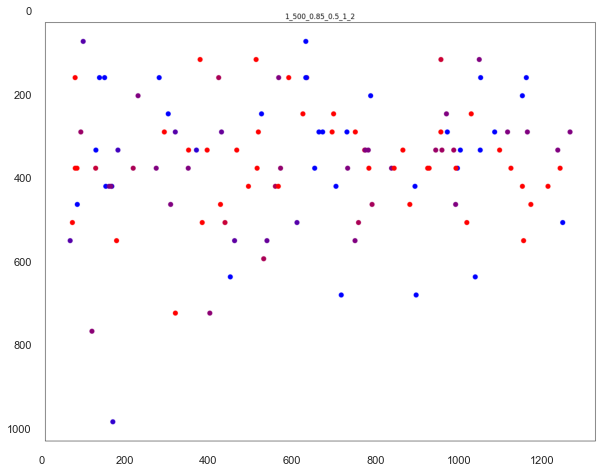

Kernel:  WL2


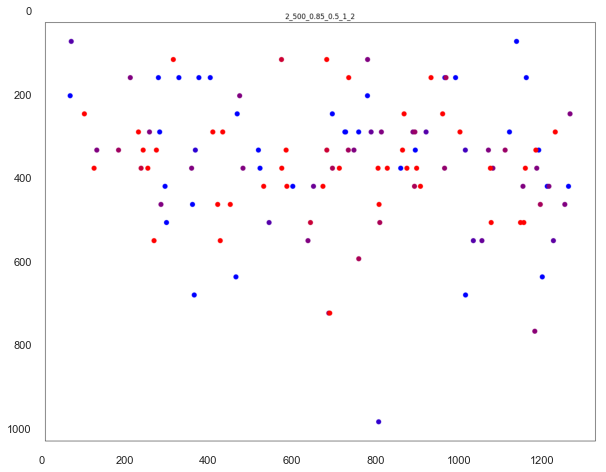

Kernel:  WL3


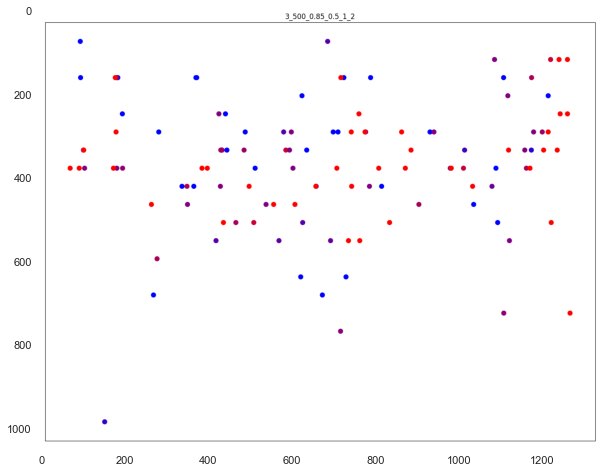

Kernel:  WL4


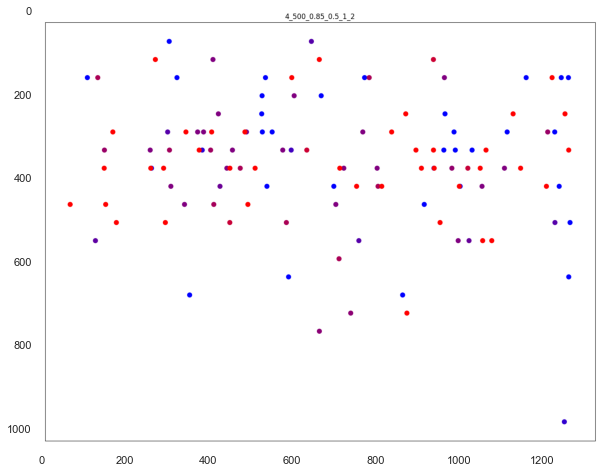

Kernel:  WL5


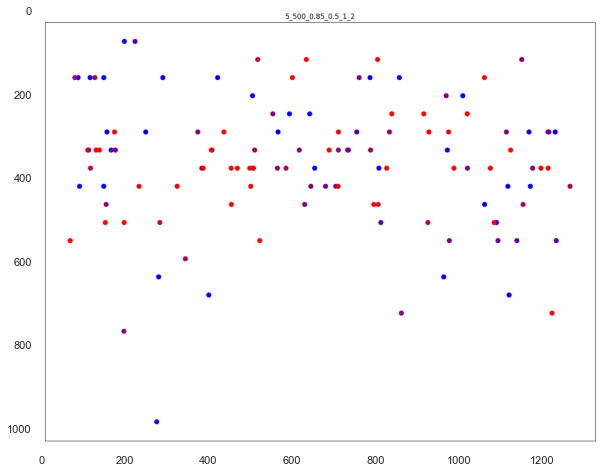

In [154]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

kernels = ["WL1", "WL2", "WL3", "WL4", "WL5"]
for i, kernel in enumerate(kernels):
    # get the image
    print("Kernel: ", kernel)
    img = mpimg.imread(f"{i+1}_500_0.85_0.5_1_2.png")
    plt.figure(figsize = (10,10))
    imgplot = plt.imshow(img)
    plt.show()

As mentioned above, the noise cluster is omitted from the plots, and one can see the allined clusters in the y axis according to the $\lambda$ value. Looking at the colors of the nodes, one cannot really find a pattern, as it seems all the graphs look somewhat similar. The absence of edges tells us that is a high correlation distance between the clusters.

## Exploring cluster sizes

Here, we are using the pickle files that contain all the necessary information about the output of ERiC. The cluster_info dictionary contains information for each cluster (partition, index within a partition, centroid, etc), while the hierarchy pickle file contains the same structure as cluster_info, but additionally contains the parents of every cluster. For convenience, we load the already computed pickle files and process the results. The pickle files are created in *kernel_computation.ipynb*.

WL1


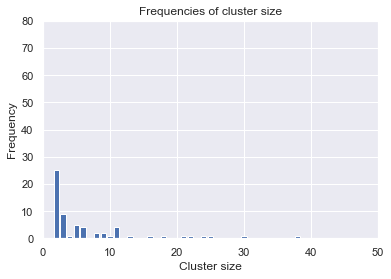

WL2


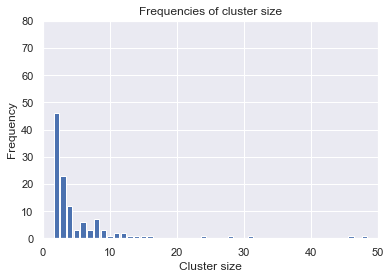

WL3


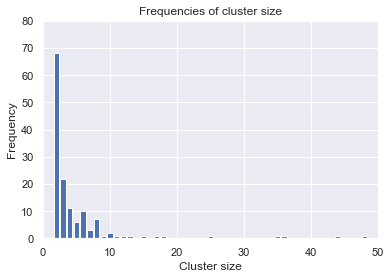

WL4


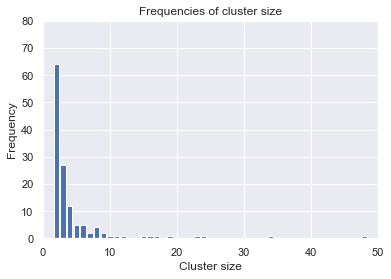

WL5


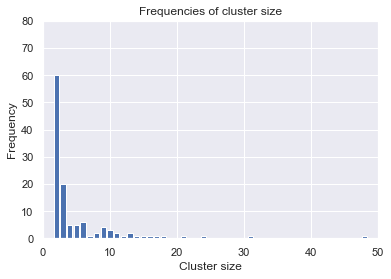

In [156]:
import os
import numpy as np
from lib import *
import pickle
from matplotlib import pyplot as plt
import collections
import seaborn as sns
sns.set_theme()

pickle_path = 'pickles'

for i, kernel in enumerate(kernels):
    cluster_info = pickle.load(open(os.path.join(pickle_path, f'cluster_info_{i+1}_500_0.85_0.5_1_2.p'), 'rb'))
    cluster_sizes = [len(cluster_info[c]["points"]) for c in cluster_info.keys()]
      
    print(kernel)

    # frequency of cluster sizes
    c = collections.Counter(cluster_sizes)
    c = sorted(c.items())
    sizes = [j[0] for j in c]
    freqs = [j[1] for j in c]
    
    plt.bar(sizes, freqs)
    plt.title("Frequencies of cluster size")
    plt.xlabel("Cluster size")
    plt.ylabel("Frequency")
    plt.xlim([0, 50])
    plt.ylim([0,80])
    plt.show()


One can observe that the cluster size distribution is somewhat similar to a power law distribution - many clusters with small sizes, while very few clusters with bigger sizes. There differences are significant in the WL4 and WL5 kernels, where there are more smaller clusters.

## Mean cluster size per dimension

WL1


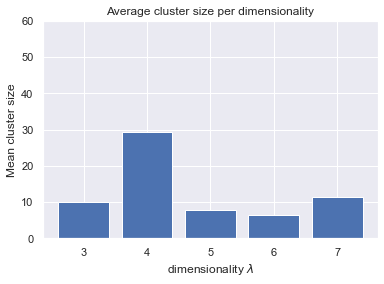

WL2


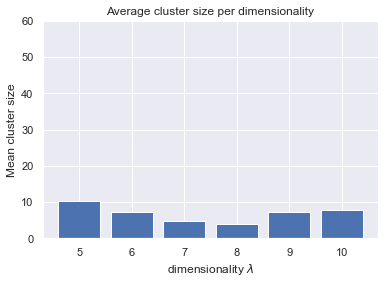

WL3


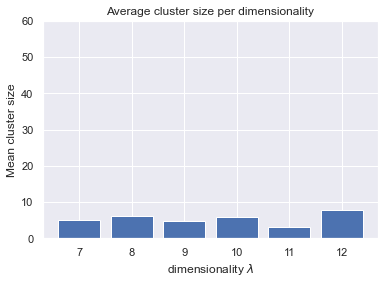

WL4


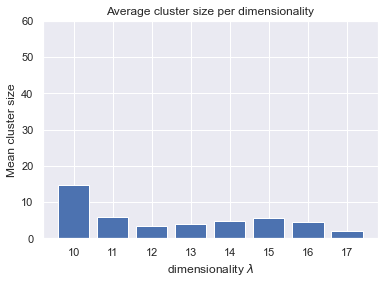

WL5


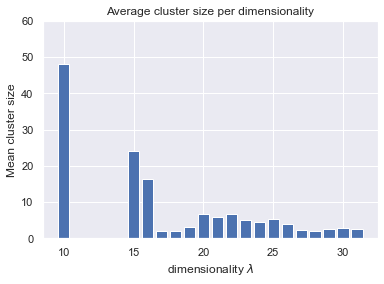

In [158]:
cluster_noise_sizes = []

for i, kernel in enumerate(kernels):
    # average size per dimension
    cluster_info = pickle.load(open(os.path.join(pickle_path, f'cluster_info_{i+1}_500_0.85_0.5_1_2.p'), 'rb'))
    lambdas = [cluster_info[c]["lambda"] for c in cluster_info.keys()]
    c_keys = [c for c in cluster_info.keys()]
    lambdas_dict = {}
    
    print(kernel)

    for l in lambdas[0:-1]:
        cluster_size = [len(cluster_info[c]["points"]) for c in cluster_info.keys() if cluster_info[c]["lambda"] == l]
        lambdas_dict[l] = sum(cluster_size)/len(cluster_size)
    
    # plot noise cluster separately
    cluster_noise_sizes.append(len(cluster_info[c_keys[-1]]["points"]))   
    
    plt.bar(lambdas_dict.keys(), lambdas_dict.values())
    plt.title("Average cluster size per dimensionality")
    plt.xlabel("dimensionality $\lambda$")
    plt.ylabel("Mean cluster size")
    plt.ylim([0,60])
    plt.show()   

Firstly, by looking at the x axis where we see all dimensionalities, we observe that if we use a bigger value for parameter *h* (number of iterations of the color refinement) of kernel WL, we see that the clusters are spread across more partitions, i.e. dimensionalities $\lambda$.   


For WL5, the average cluster size in the lower partitions is much larger, while the others seem to have somewhat similar average cluster sizes.

## Noise space

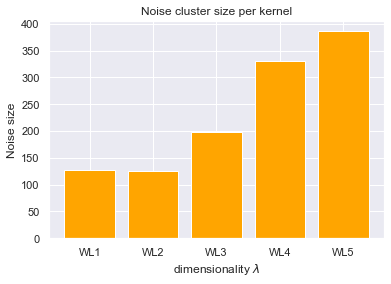

In [159]:
# plot noise sizes
plt.bar(kernels, cluster_noise_sizes, color="orange")
plt.title("Noise cluster size per kernel")
plt.xlabel("dimensionality $\lambda$")
plt.ylabel("Noise size")
plt.show()

It is interesting to see that the higher the parameter *h* of the WL kernel, causes more points to be accumulated in the noise cluster. The noise cluster is jointly filled with points by the point partitioning in ERiC, and by the DBSCAN algorithm which also outputs a cluster of noisy points within every partition. 

### Class label distribution

WL1


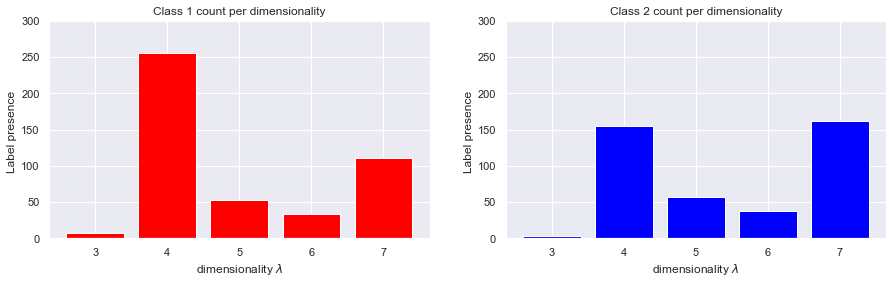

WL2


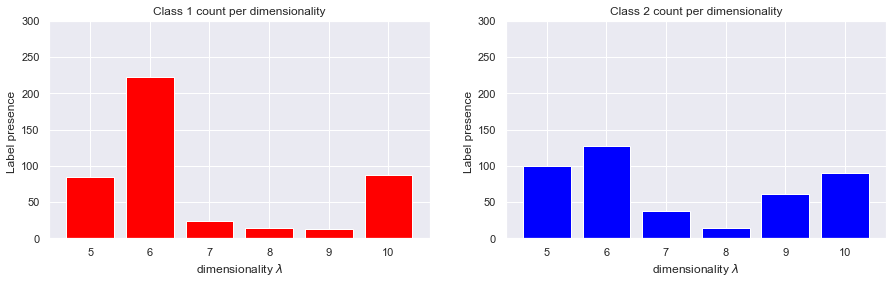

WL3


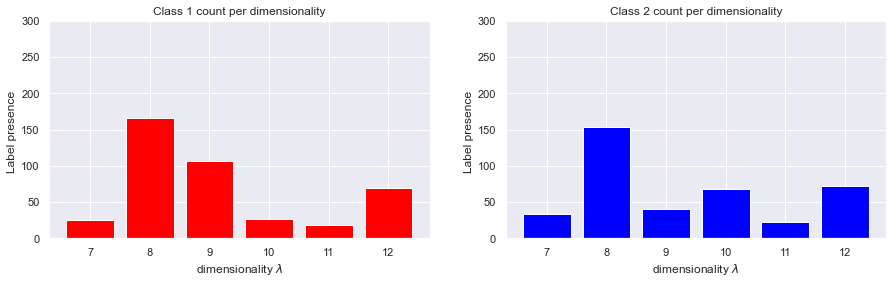

WL4


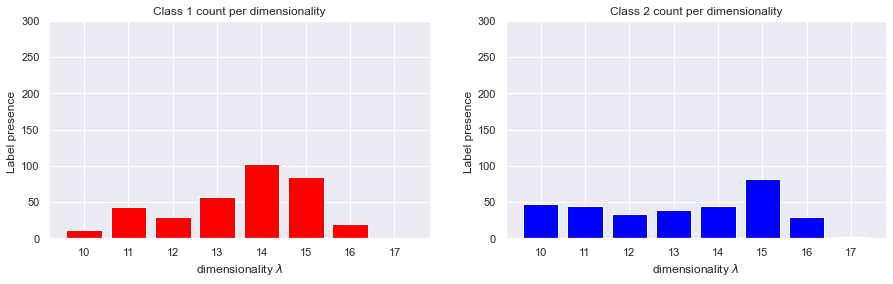

WL5


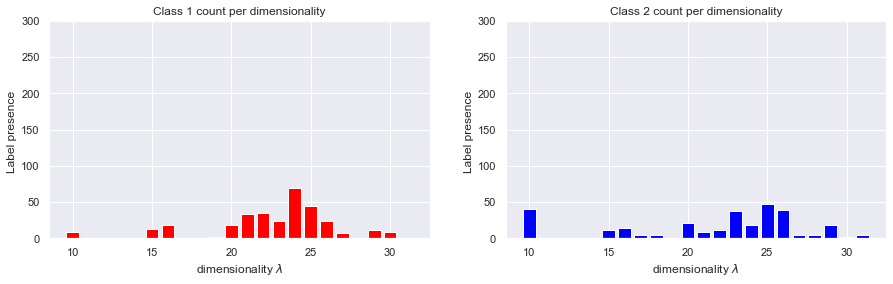

In [161]:
for i, kernel in enumerate(kernels):
    # average size per dimension
    cluster_info = pickle.load(open(os.path.join(pickle_path, f'cluster_info_{i+1}_500_0.85_0.5_1_2.p'), 'rb'))
    lambdas = [cluster_info[c]["lambda"] for c in cluster_info.keys()]
    
    print(kernel)
    
    class_1_list = []
    class_2_list = []
    for l in lambdas[0:-1]:
        class_1 = [np.count_nonzero(np.array(cluster_info[c]['points']) > 499) for c in cluster_info.keys() if cluster_info[c]["lambda"] == l]
        class_2 = [np.count_nonzero(np.array(cluster_info[c]['points']) <= 500) for c in cluster_info.keys() if cluster_info[c]["lambda"] == l]
        
        class_1_list.append(sum(class_1))
        class_2_list.append(sum(class_2))
            

    fig, axs = plt.subplots(1,2)
    fig.set_figwidth(15)
    axs[0].bar(lambdas[0:-1], class_1_list, color="red")
    axs[0].set_title("Class 1 count per dimensionality")
    axs[0].set_xlabel("dimensionality $\lambda$")
    axs[0].set_ylabel("Label presence ")
    axs[0].set_ylim([0, 300])
    
    axs[1].bar(lambdas[0:-1], class_2_list, color="blue")
    axs[1].set_title("Class 2 count per dimensionality")
    axs[1].set_xlabel("dimensionality $\lambda$")
    axs[1].set_ylabel("Label presence ")
    axs[1].set_ylim([0, 300])
    
    plt.show() 

Firstly, one can observe that the number of points per dimensionalities varies a lot in all kernels. Secondly, it seems that increasing parameter *h* causes the spread of both classes to be somewhat equal in each partition.

## NMI between different kernel clusterings

In [152]:
from sklearn.metrics import normalized_mutual_info_score

all_labels = []
for i, kernel in enumerate(kernels):
    # average size per dimension
    cluster_info = pickle.load(open(os.path.join(pickle_path, f'cluster_info_{i+1}_500_0.85_0.5_1_2.p'), 'rb'))
    c_keys = [c for c in cluster_info.keys()]

    cluster_size = [len(cluster_info[i]["points"]) for i in cluster_info.keys()]
    labels = []
    indices = []
    for i, value in enumerate(cluster_size):
        labels.extend(np.repeat(i, value))
        indices.extend(cluster_info[i+1]["points"])
        sort_inx = np.argsort(indices)
        labels = [labels[i] for i in sort_inx]
        
    all_labels.append(labels)
    
# add ground truth
true_labels = np.zeros(len(all_labels[0]))
true_labels[499:] = 1 
all_labels.append(true_labels)

results = np.zeros((len(kernels)+1,len(kernels)+1))
for i in range(len(results[0])):
    for j in range(len(results[0])):
        results[i,j] = normalized_mutual_info_score(all_labels[i],all_labels[j])


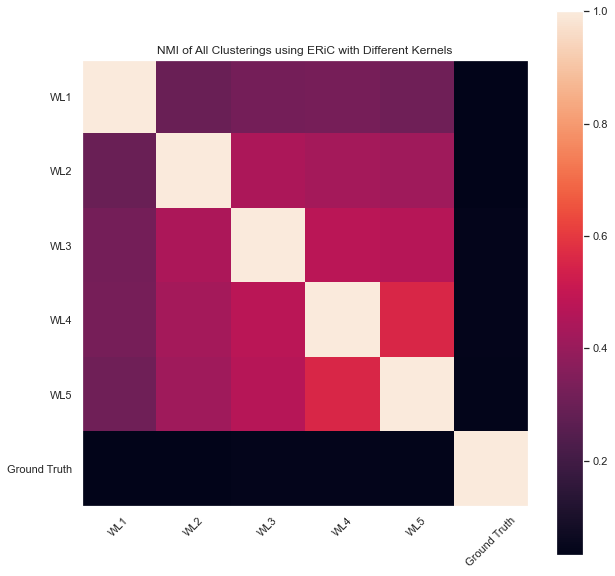

In [153]:
plt.figure(figsize=(10,10))

plt.xticks(range(len(kernels)+1),["WL1","WL2","WL3","WL4","WL5","Ground Truth"], rotation = 45)
plt.yticks(range(len(kernels)+1),["WL1","WL2","WL3","WL4","WL5","Ground Truth"])
plt.title("NMI of All Clusterings using ERiC with Different Kernels")
plt.rcParams['axes.grid'] = False
plt.imshow(results)
plt.colorbar()

Similarly as in the previous EDA, one can observe that WL4 and WL5 have very similar clusterings and none of the kernel clusterings match up well at all with the ground truth labelings. This indicates that the ground truth labelings are not very related to the graph structure itself.

## Improvements

Considering both EDAs, it seems that there is no obvious relation between clustering and classifying the dataset according to genres. For this dataset, we suspect that supervised learning would give better results.

In this setting, it does not seem that there is a correlation among clusters in different subspaces, however, one can try several ideas to try to improve the results: Obtaining more datasets so that a higher k can be set, trying out different $\alpha$ values, finding the optimal parameters for DBSCAN for every dimension separately and not using global ones. Improving the feature engineering can be also helpful, since we found a difference in node degrees between the clases, hence there could be also some additional features that the kernels are not able to capture. 